In [1]:
import numpy      as     np
from   scipy      import stats  as stats
from   matplotlib import pyplot as plt

In [2]:
num_train = int(1e5)
noise_size = 1000

train_masses = [120., 130., 140.]

In [3]:
range_min, range_max = 105, 160
range_width = range_max - range_min
plot_resolution = 0.5

w1, m1, s1 = .3, 125, 1.8
C2 = -1.
w2, A2, B2 = 0., 0., -1.*C2*(range_max-range_min)

def bkg_func (x) :
    x_prime = x-range_min
    return A2 + B2*(x_prime) + C2*np.multiply(x_prime, x_prime)

def int_bkg_func (lower, upper) :
    lower, upper = lower-range_min, upper-range_min
    L = A2*lower + B2*np.multiply(lower, lower)/2. + C2*np.multiply(np.multiply(lower, lower), lower)/3.
    U = A2*upper + B2*np.multiply(upper, upper)/2. + C2*np.multiply(np.multiply(upper, upper), upper)/3.
    return U - L

N_1 = w1 / (w1 + w2) / (stats.norm.cdf(range_max, m1, s1) - stats.norm.cdf(range_min, m1, s1))
N_2 = w2 / (w1 + w2) / int_bkg_func(range_min, range_max)

def true_pdf (x) :
    return N_1*stats.norm.pdf(x, m1, s1) + N_2*bkg_func(x)

def true_cdf (x) :
    return N_1*stats.norm.cdf(x, m1, s1) + N_2*int_bkg_func(range_min, x)

In [4]:
def generate_data (num_pnts, mass=125., resolution=0.01) :
    global m1
    m1 = mass
    x = np.linspace(range_min, range_max, 1+int(1./resolution))
    y = true_cdf(x)
    p = np.random.uniform(0, 1, size=(num_pnts,))
    return np.interp(p, y, x)

In [5]:
def plot_points (data_115, data_130, data_145, label) :
    x = np.linspace(range_min, range_max, 1000)
    h0 = plt.hist(data_115, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue"  , density=True, label=f"{label}"+r" ($m="+f"{train_masses[0]:.0f}"+r"~{\rm GeV}$)")
    h1 = plt.hist(data_130, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="purple", density=True, label=f"{label}"+r" ($m="+f"{train_masses[1]:.0f}"+r"~{\rm GeV}$)")
    h2 = plt.hist(data_145, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="red"   , density=True, label=f"{label}"+r" ($m="+f"{train_masses[2]:.0f}"+r"~{\rm GeV}$)")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=15)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=35, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    plt.gca().set_ylim([0, 1.5*max([max(h0[0]), max(h1[0]), max(h2[0])])])
    plt.show()

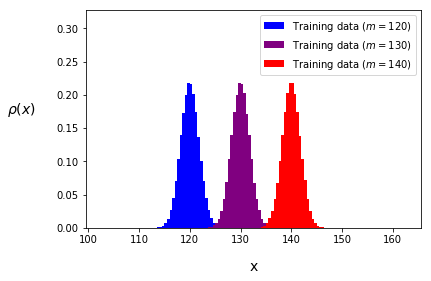

In [6]:
train_DS_115 = generate_data(num_train, mass=train_masses[0])
train_DS_130 = generate_data(num_train, mass=train_masses[1])
train_DS_145 = generate_data(num_train, mass=train_masses[2])
plot_points(train_DS_115, train_DS_130, train_DS_145, "Training data")

In [21]:
from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate
from keras.models     import Model, Sequential
from keras.optimizers import Adam

import keras.backend as K


d1_in = Input((1,))
d1 = Dense(32, activation="relu")(d1_in)
d1 = Dropout(0.2)(d1)

hyper_in = Input((1,))
d2 = Dense(32, activation="relu")(hyper_in)
d2 = Dropout(0.2)(d2)

dc = Concatenate()([d1, d2])
dc = Dense(32 , activation="relu")(dc)
dc = Dropout(0.2)(dc)
dc = Dense(64 , activation="relu")(dc)
dc = Dense(2, activation="softmax")(dc)

dc = Model(name="Discriminator", inputs=[d1_in, hyper_in], outputs=[dc])
dc.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
# 0.0005, beta_1=0.5
dc.summary()


g1_in = Input((noise_size,))
g1 = Dense(32, activation="relu")(g1_in)
g1 = BatchNormalization()(g1)

g2 = Dense(32, activation="relu")(hyper_in)
g2 = BatchNormalization()(g2)

gc = Concatenate()([g1, g2])
gc = Dense(64, activation="relu")(gc)
gc = BatchNormalization()(gc)
gc = Dense(64, activation="relu")(gc)
gc = Dense(1, activation="linear")(gc)

gc = Model(name="Generator", inputs=[g1_in, hyper_in], outputs=[gc])
gc.summary()


gan_out = dc([gc([g1_in, hyper_in]), hyper_in])
gan = Model([g1_in, hyper_in], gan_out, name="GAN")
dc.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
gan.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 32)           64          input_16[0][0]                   
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 32)           64          input_17[0][0]                   
______________________________________________________________________________________

In [22]:
def plot_points_GAN (gen_data, train_data, epoch, batch_size, d_acc) :
    gen_class_length = int(gen_data.shape[0]/3)
    gen_data_115 = gen_data[:gen_class_length                    ,0]
    gen_data_130 = gen_data[gen_class_length  :2*gen_class_length,0]
    gen_data_145 = gen_data[2*gen_class_length:3*gen_class_length,0]
    tr_class_length = int(train_data.shape[0]/3)
    train_data_115 = train_data[:tr_class_length                   ,0]
    train_data_130 = train_data[tr_class_length  :2*tr_class_length,0]
    train_data_145 = train_data[2*tr_class_length:3*tr_class_length,0]
    print(np.mean(gen_data_115), np.std(gen_data_115))
    print(np.mean(gen_data_130), np.std(gen_data_130))
    print(np.mean(gen_data_145), np.std(gen_data_145))
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1, 2, 1)
    h0 = plt.hist(gen_data_115, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue"  , density=True, label=r"Generated data ($m="+f"{train_masses[0]:.0f}"+r"~{\rm GeV}$)")
    h1 = plt.hist(gen_data_130, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="purple", density=True, label=r"Generated data ($m="+f"{train_masses[1]:.0f}"+r"~{\rm GeV}$)")
    h2 = plt.hist(gen_data_145, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="red"   , density=True, label=r"Generated data ($m="+f"{train_masses[2]:.0f}"+r"~{\rm GeV}$)")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=10)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    y_max = 1.5*np.max([max(h0[0]), max(h1[0]), max(h2[0])])
    if np.isnan(y_max) : y_max = 1.0
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.*1.1*range_width   , 0.88*y_max, "Conditional", size=14, style="italic", weight="bold")
    plt.text(range_min+0.*1.1*range_width   , 0.80*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.780*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.713*1.1*range_width, 0.61*y_max, f"Batch size: {gen_class_length}")
    plt.text(range_min+0.810*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    fig.add_subplot(1, 2, 2)
    h0_2 = plt.hist(train_data_115, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue"  , density=True, label=r"Training data ($m="+f"{train_masses[0]:.0f}"+r"~{\rm GeV}$)")
    h1_2 = plt.hist(train_data_130, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="purple", density=True, label=r"Training data ($m="+f"{train_masses[1]:.0f}"+r"~{\rm GeV}$)")
    h2_2 = plt.hist(train_data_145, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="red"   , density=True, label=r"Training data ($m="+f"{train_masses[2]:.0f}"+r"~{\rm GeV}$)")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=10)
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    y_max = 1.5*np.max([max(h0_2[0]), max(h1_2[0]), max(h2_2[0])])
    if np.isnan(y_max) : y_max = 1.0
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.*1.1*range_width   , 0.88*y_max, "Conditional", size=14, style="italic", weight="bold")
    plt.text(range_min+0.*1.1*range_width   , 0.80*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.780*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.713*1.1*range_width, 0.61*y_max, f"Batch size: {tr_class_length}")
    plt.text(range_min+0.810*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    plt.savefig(f"out/1D_GAN_test/Train_epoch{epoch}.png", dpi=96)
    plt.show()

123.13699 2.9999046
125.49298 4.647339
141.69235 1.9673824


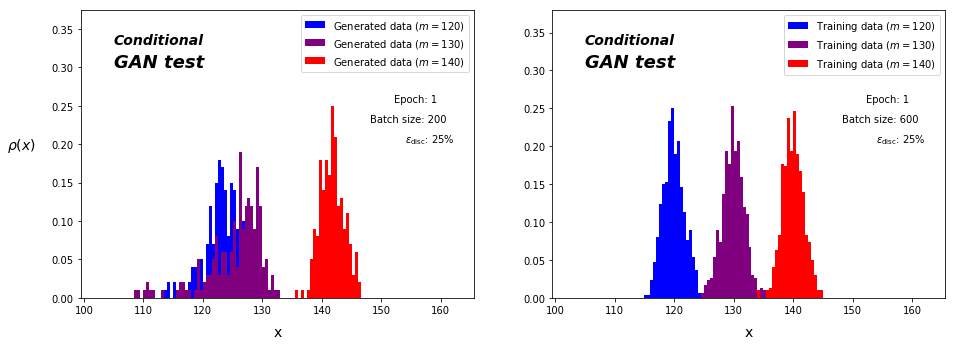

KeyboardInterrupt: 

In [25]:
#  Train GAN

epochs     = 10000
batch_size = 200
rel_batch_size = 3
max_D_itrs_per_G_itr_e80 = 1
max_D_itrs_per_G_itr_e52 = 2

def update_batch_size (gen_DS, e) :
    global batch_size
    batch_size = min(max(batch_size, 100+int((e+1)/10.)), num_train)
    
def get_noise () :
    hyperparams = np.concatenate([np.full(fill_value=120., shape=(batch_size, 1)),
                                  np.full(fill_value=125., shape=(batch_size, 1)),
                                  np.full(fill_value=145., shape=(batch_size, 1))])
    return np.random.normal(size=(3*batch_size, noise_size)), hyperparams

def get_train_data () :
    batch_115 = train_DS_115[np.random.randint(0, len(train_DS_115), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    batch_130 = train_DS_130[np.random.randint(0, len(train_DS_130), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    batch_145 = train_DS_145[np.random.randint(0, len(train_DS_145), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    hyperparams = np.concatenate([np.full(fill_value=120., shape=(rel_batch_size*batch_size, 1)),
                                  np.full(fill_value=125., shape=(rel_batch_size*batch_size, 1)),
                                  np.full(fill_value=145., shape=(rel_batch_size*batch_size, 1))])
    return np.concatenate([batch_115, batch_130, batch_145]), hyperparams
  
epochs_saved = []
for e in range(epochs) :
    noise, noise_hyperparams    = get_noise()
    batch_DS, batch_hyperparams = get_train_data()
    gen_DS   = gc.predict([noise, noise_hyperparams])
    real_label  = np.array([[1., 0.] for i in range(3*rel_batch_size*batch_size)])
    fake_label  = np.array([[0., 1.] for i in range(3*batch_size)])
    train_label = np.array([[1., 0.] for i in range(3*batch_size)])
    X  = np.concatenate([batch_DS  , gen_DS    ])
    Xh = np.concatenate([batch_hyperparams  , noise_hyperparams    ])
    Y = np.concatenate([real_label, fake_label])
    W = np.concatenate([np.ones(shape=(batch_DS.shape[0],)), np.full(fill_value=rel_batch_size, shape=(gen_DS.shape[0],))])
    
    dc.trainable = True
    d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)
    num_itr = 0
    while num_itr < max_D_itrs_per_G_itr_e80 and d_acc < 0.8 :
        d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)
        num_itr = num_itr + 1
    while num_itr < max_D_itrs_per_G_itr_e52 and d_acc < 0.52 :
        d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)
        num_itr = num_itr + 1
        
    noise, noise_hyperparams = get_noise()
    dc.trainable = False
    gan.train_on_batch([noise, noise_hyperparams], train_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise, noise_hyperparams = get_noise()
        gen_DS = gc.predict([noise, noise_hyperparams])
        plot_points_GAN(
                    gen_DS,
                    batch_DS,
                    epoch=e+1, 
                    batch_size=batch_size, 
                    d_acc=dc.evaluate([X, Xh], Y, sample_weight=W, verbose=0)[1])
        update_batch_size(gen_DS, e)
        epochs_saved.append(e+1)



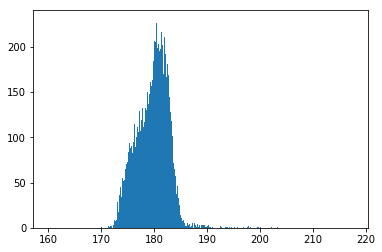

          MASS = 170.0
GENERATED MEAN = 179.7


In [28]:
mass = 170.

hyperparams = np.full(fill_value=mass, shape=(10000, 1))
z = np.random.normal(size=(10000, noise_size))
datapoints = gc.predict([z, hyperparams])[:,0]

plt.hist(datapoints, bins=np.linspace(min(datapoints)-10, max(datapoints)+10, 401))
plt.show()

print(f"          MASS = {mass}")
print(f"GENERATED MEAN = {np.mean(datapoints):.1f}")